Adapted in notebook GP_S+L pulse_kernel_mixture_of_2_terms:
- Use data file sim_pulse.lc
- Use the two SHOTerms of the step by step notebook

In [1]:
import os
import sys

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

 # Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from plot_helpers import *
plotter = PlotUtilSPLeaf()

In [2]:
import math
%load_ext autoreload
%autoreload 2

import numpy as np
np.random.seed(0)

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

In [3]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

Read the first time series

In [4]:
df = pd.read_csv("data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')

In [5]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
## Plot the data

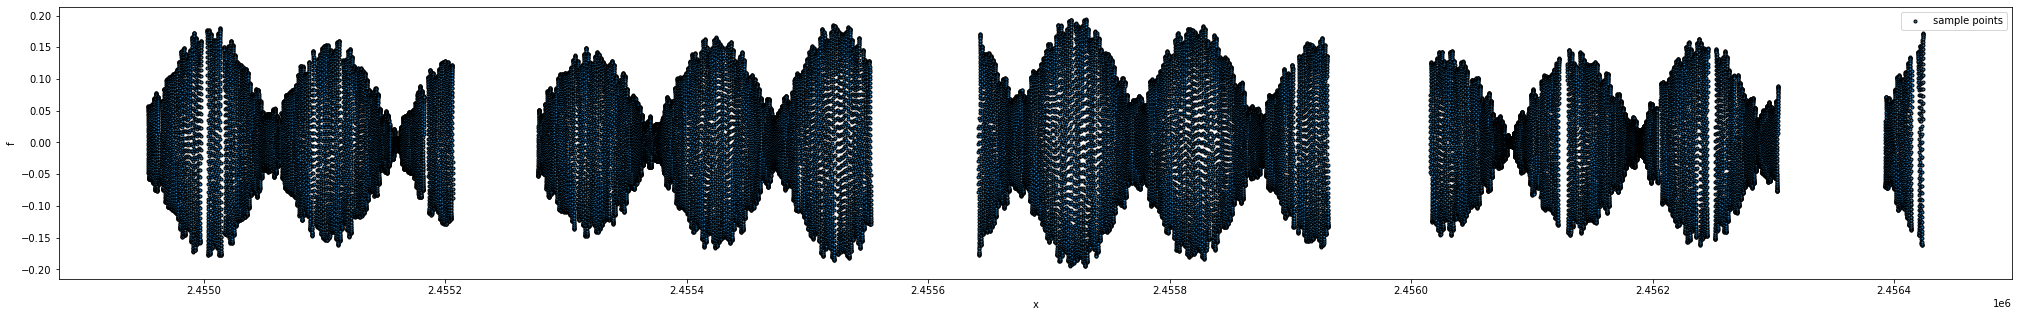

In [6]:
plotter.plot_data(X, Y)

Zoomed in on the first N observations

In [7]:
# This library becomes unstable at N=15125
# N=15125
N=X.shape[0]
N_part=15000

In [8]:
X_part=X[:N_part]
Y_part=Y[:N_part]

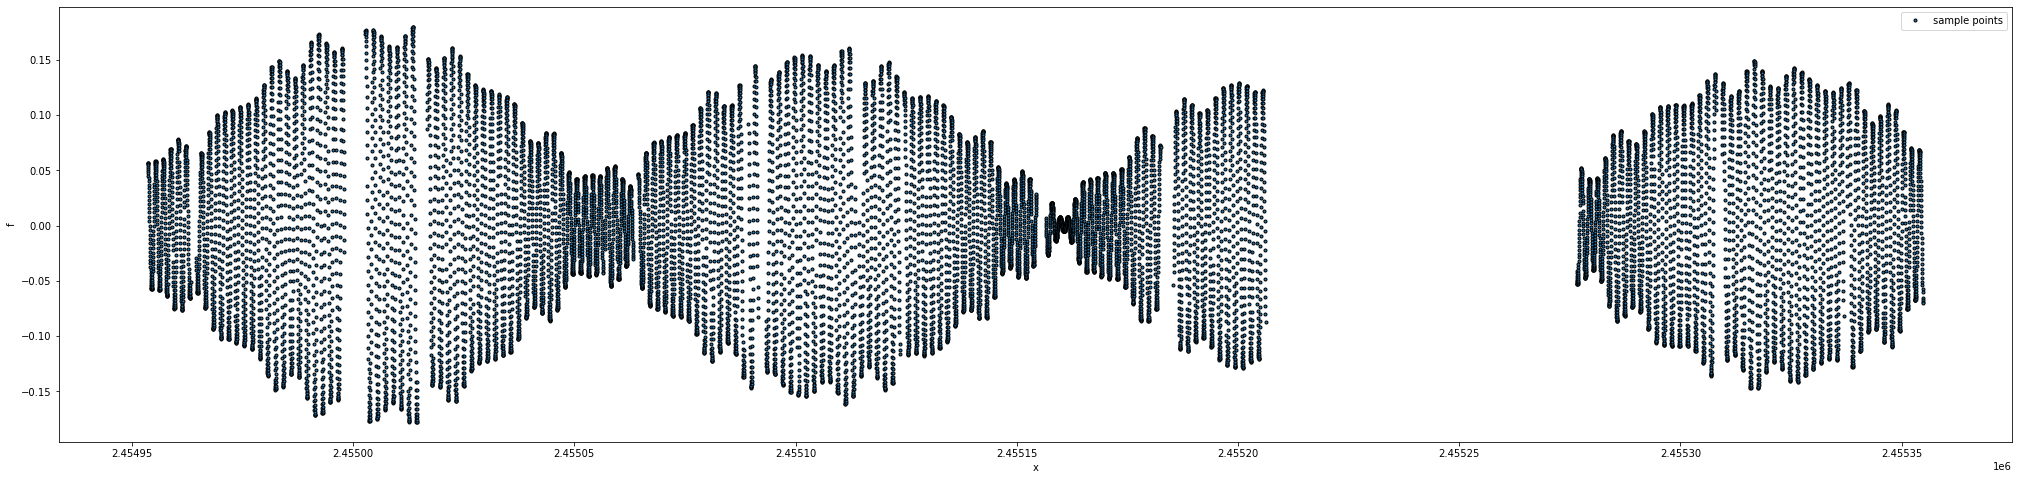

In [9]:
plotter.plot_data(X_part, Y_part, fig_height=8)

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [10]:
# Predict evenly spaced points on our time-axis
X_part_smooth = np.linspace(X_part.min(), X_part.max(), N_part)

In [11]:
# Define the function to minimize
def negloglike(x, y, cov_matrix):
   cov_matrix.set_param(x)
   nll = -cov_matrix.loglike(y)
   # gradient
   nll_grad = -cov_matrix.loglike_grad()[1]
   return(nll, nll_grad)

In [12]:
# Initialize the S+LEAF model
cov_matrix = cov.Cov(X_part,
   sho1 = term.SHOKernel(sig=1.205186, P0=2, Q=150000.36505),
#   sho2 = term.SHOKernel(sig=1.205186, P0=2.1, Q=150000.36505),
#   sho3 = term.SHOKernel(sig=1.205186, P0=10, Q=150000.36505),
                    )

In [13]:
# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
# xbest,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix.get_param(), args=(Y_part, cov_matrix))
# cov_matrix.set_param(xbest)

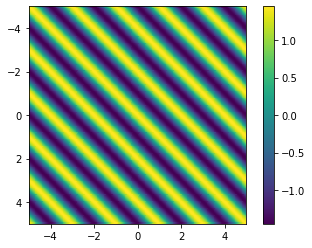

In [14]:
plotter.plot_2d_kernel(cov_matrix)

In [15]:
plotter.plot_1d_kernel(cov_matrix)

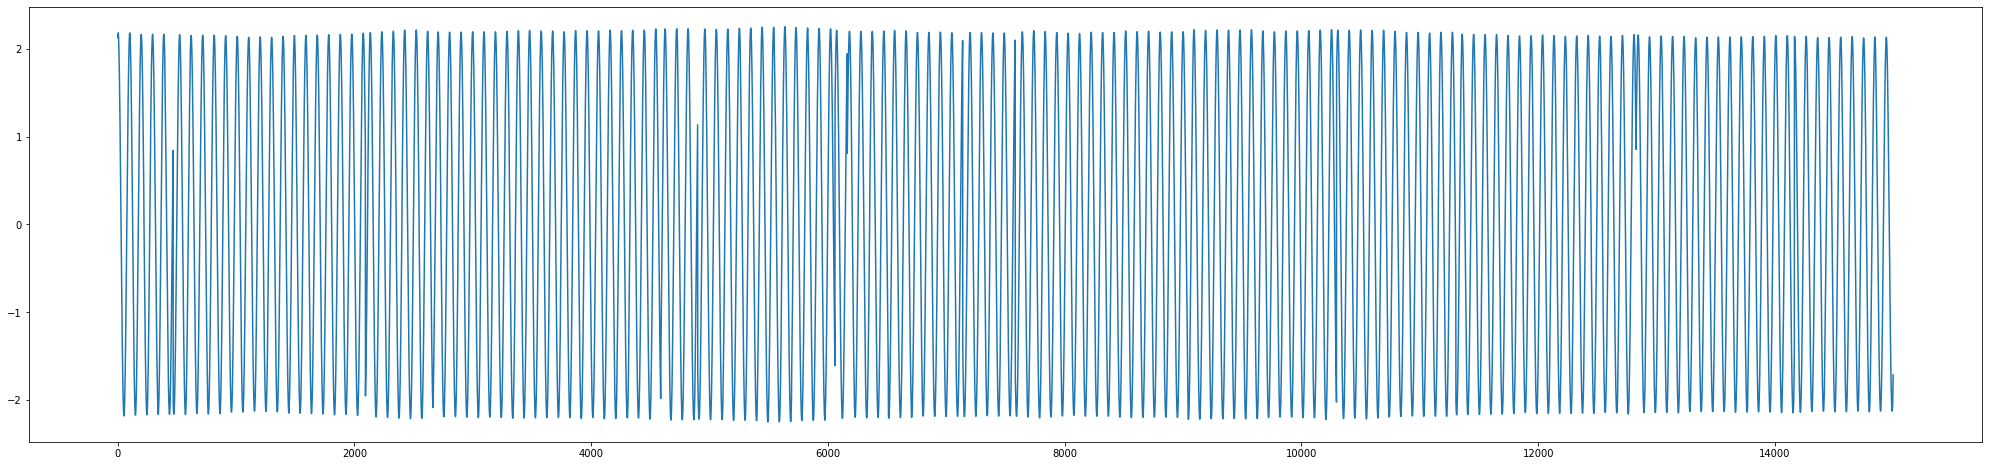

In [16]:
plotter.plot_kernel_samples(cov_matrix, nr_of_samples=1)

In [17]:
# We now use S+LEAF to predict the missing data on the training data scope
mu_part_smooth, var_part_smooth = cov_matrix.conditional(Y_part, X_part_smooth, calc_cov='diag')

In [18]:
plotter.plot_series(X_part, Y_part, X_part_smooth, mu_part_smooth, var_part_smooth)

In [19]:
mu_part_smooth

array([ 0.0569707 ,  0.05664396,  0.05583184, ..., -0.06587208,
       -0.06822839, -0.07000665])

In [20]:
# Our mean function was not specified so should be 0, check that the average of all 
# datapoints is (close to) 0
mu_part_smooth.mean()

-2.282798873684344e-06

In [21]:
# What about the variance? Is this supposed to mean something?
mu_part_smooth.var()

0.005898840977833407

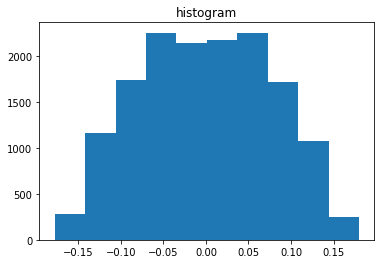

In [22]:
plt.hist(mu_part_smooth) 
plt.title("histogram") 
plt.show()

## Explore the parameters of the fitted model

In [23]:
cov_matrix.param

['sho1.sig', 'sho1.P0', 'sho1.Q']

In [24]:
cov_matrix.get_param('sho1.sig'), cov_matrix.get_param('sho1.P0'), cov_matrix.get_param('sho1.Q'),\
cov_matrix.get_param('sho2.sig'), cov_matrix.get_param('sho2.P0'), cov_matrix.get_param('sho2.Q')

KeyError: 'sho2.sig'

## Model Evaluation

RMSE

In [ ]:
mu_part, var_part = cov_matrix.conditional(Y_part, X_part, calc_cov='diag')

np.sqrt(np.nanmean((mu_part-Y_part)**2))

RMSE per x

In [ ]:
np.sqrt(np.nanmean((mu_part-Y_part)**2))/N_part

# Residuals

In [ ]:
resid1_part = Y_part - mu_part

In [ ]:
Y_part, mu_part, resid1_part

In [ ]:
plotter.plot_series(X_part, resid1_part)

Strange that we do not get the same results as the step-by-step kernel!!

The residuals are very small compared to Y.
Yet, there is still a periodic signal, this is not stationary yet